In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Data collection

In [45]:
from tensorflow.examples.tutorials.mnist import input_data
df = input_data.read_data_sets("/home/radial/MNIST_data")

Extracting /home/radial/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/radial/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/radial/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/radial/MNIST_data/t10k-labels-idx1-ubyte.gz


In [46]:
df.train.labels

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [47]:
data = input_data.read_data_sets("/home/radial/MNIST_data", one_hot=True)
data.train.labels

Extracting /home/radial/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/radial/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/radial/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/radial/MNIST_data/t10k-labels-idx1-ubyte.gz


array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [48]:
print(len(df.train.labels),len(df.test.labels))

55000 10000


In [49]:
data.test.cls = np.array([label.argmax() for  label in data.test.labels])

# Fixed parameters

In [58]:
img_size = 28
flat = img_size**2
img_shape = (img_size,img_size)
classes = 10

#  Graph

In [8]:
x = tf.placeholder(tf.float32,[None, flat]) # this placehoder can allow any number of rows

In [9]:
y_real = tf.placeholder(tf.float32,[None, classes]) # one hotted

In [10]:
y_real_class =  tf.placeholder(tf.int64,[None])

In [11]:
weight = tf.Variable(tf.zeros([flat,classes]))

In [12]:
bais = tf.Variable(tf.zeros([classes]))

# Model

In [13]:
logits = tf.matmul(x,weight)+bais

In [14]:
y_pred = tf.nn.softmax(logits)
y_pred_class = tf.arg_max(y_pred,dimension=1)

# Cost function

In [15]:
x_entropy =  tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_real)

In [16]:
cost = tf.reduce_mean(x_entropy)

# Optimization

In [17]:
#opti = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
opti = tf.train.RMSPropOptimizer(learning_rate=0.1).minimize(cost)


# Metrics

In [18]:
cor_pred = tf.equal(y_pred_class, y_real_class)
accuracy = tf.reduce_mean(tf.cast(cor_pred, tf.float32))

# Session

In [19]:
session = tf.Session()

In [20]:
session.run(tf.global_variables_initializer())

In [21]:
batch = 500

In [22]:
# to make images go in batch
def opt(num):
    for i in range(num):
        x_batch , y_true_batch = data.train.next_batch(batch) # random batch generation
        feed_dict_train = {x:x_batch, y_real:y_true_batch} # to connect to placehoderz
        session.run(opti, feed_dict=feed_dict_train)

In [23]:
feed_dict_test = {x:data.test.images ,
                  y_real:data.test.labels,
                  y_real_class:data.test.cls} # to connect to placehoderz

In [24]:
def show_acc():
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    #print("Accuracy on test set: {0:.1%}".format(acc))
    return(acc)

In [29]:
def show_conf_mat():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_class,  feed_dict=feed_dict_test)
    cm =confusion_matrix(y_true = cls_true,y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation="nearest",cmap = plt.cm.Blues)

In [26]:
s = []
for i in range(50):
    opt(i)
    s.append(show_acc())

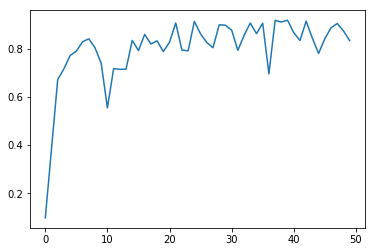

In [27]:
plt.plot(s)

[[ 914    0   13    3    0   18   25    1    0    6]
 [   0 1101   12    3    0    1   10    2    2    4]
 [   3    0  984    7    1    4   14    5    6    8]
 [   0    0   48  904    0   13    6    4    1   34]
 [   0    0   38    2  421    0   71    9   10  431]
 [   4    3   18   44    2  741   44    4    9   23]
 [   3    2   12    1    1    8  930    1    0    0]
 [   0    3   42   10    0    0    0  755    0  218]
 [   7    5   94   38    2   35   44    5  611  133]
 [   5    1    6    9    1    3    2    4    0  978]]


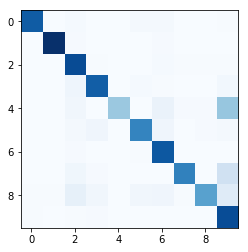

In [30]:
show_conf_mat()

# CNN

In [51]:
import math

In [52]:
import time
from datetime import timedelta

# Parameters

In [53]:
con_fil_size1 = 5
num_con_fil1 = 20

con_fil_size2 = 5
num_con_fil2 = 40

full_lay = 128

channel = 1

# Hyperparameters

In [54]:
def new_weights(shape):
    return(tf.Variable(tf.truncated_normal(shape,stddev=0.5)))
def new_bais(length):
    return(tf.Variable(tf.constant(0.05, shape = [length])))

In [55]:
def con_lay(input, num_inp_channel, filter_size,num_filters, use_pooling = True):
    shape = [filter_size,filter_size,num_inp_channel,num_filters]
    weights = new_weights(shape)
    bias = new_bais(num_filters)
    
    layer = tf.nn.conv2d(input, filter=weights, strides=[1,1,1,1],padding='SAME')
    layer = layer +bias
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    layer = tf.nn.relu(layer)
    return (layer,weight)

In [56]:
def flat(layer):
    layer_shape = layer.get_shape()
    num_features = np.array(layer_shape[1:4],dtype=int).prod()
    layer_flat = tf.reshape(layer,[-1,num_features])
    return (layer_flat,num_features)

In [57]:
def fc_layer(input , num_inputs, num_outputs, use_relu = True):
    weights = new_weights(shape=[num_inputs,num_outputs])
    biases = new_bais(lenght = num_outputs)
    layer = tf.matmul(input,weights)+biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer
    

In [61]:
x = tf.placeholder(tf.float32, shape = [None, flat], name ='x')
x_image = tf.reshape(x,[-1,img_size,img_size,channel])
y_true = tf.placeholder(tf.float32, shape = [None,10], name ='y_true')
y_true_cls = tf.argmax(y_true,dimension=1)

In [ ]:
layer_conv1, weight_conv1 = con_lay(x_image,channel,)